In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
file_path = 'C:/Users/BERKAN/Desktop/IT/Data Science/DataProjeler/ArabaFiyatları/car_prices.csv'
df = pd.read_csv(file_path)
import warnings

warnings.filterwarnings('ignore')
sns.set_style()
df['transmission'] = df['transmission'].str.replace('Sedan', 'sedan')
df['transmission'].fillna('automatic', inplace=True)
df=df.dropna()
# condition veri setinde nümerik bir değer gibi gözükse de aslında 1 den 50ye kadar aracın -
#fiziksel durumunu gösteren kategorik bir değişken öncelikle bunu düzeltmemiz gerekiyor
# DataFrame oluşturma
df_condition = pd.DataFrame(df['condition'])

# Kategorilere ayırma
def categorize_condition(value):
    if 1 <= value <= 10:
        return 'Çok Kötü'
    elif 11 <= value <= 20:
        return 'Kötü'
    elif 21 <= value <= 30:
        return 'Orta'
    elif 31 <= value <= 40:
        return 'İyi'
    elif 41 <= value <= 49:
        return 'Mükemmel'

# Yeni kategori sütunu ekleyelim
df_condition['category'] = df_condition['condition'].apply(categorize_condition)

df_condition.drop('condition',axis=1,inplace=True)
df.drop('condition',axis=1,inplace=True)
df['category']=df_condition['category']
df.rename(columns={'category': 'condition_categoric'}, inplace=True)
## Vin değeri benzersiz olmalı bu yüzden tekrar edenleri drop edeceğiz 
df = df.drop_duplicates(subset='vin', keep='first')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525638 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 525638 non-null  int64  
 1   make                 525638 non-null  object 
 2   model                525638 non-null  object 
 3   trim                 525638 non-null  object 
 4   body                 525638 non-null  object 
 5   transmission         525638 non-null  object 
 6   vin                  525638 non-null  object 
 7   state                525638 non-null  object 
 8   odometer             525638 non-null  float64
 9   color                525638 non-null  object 
 10  interior             525638 non-null  object 
 11  seller               525638 non-null  object 
 12  mmr                  525638 non-null  float64
 13  sellingprice         525638 non-null  float64
 14  saledate             525638 non-null  object 
 15  condition_categoric  5

In [3]:
df.isnull().sum()

year                   0
make                   0
model                  0
trim                   0
body                   0
transmission           0
vin                    0
state                  0
odometer               0
color                  0
interior               0
seller                 0
mmr                    0
sellingprice           0
saledate               0
condition_categoric    0
dtype: int64

#### Kategorik bağımsız değişkenler için outlier analizi

##### Kruskall-wallis-H testlerinin sonuçlarını göz önüne alarak makine öğrenmesi sürecine sadece transmission,trim,color,make,model kategorik değişkenlerini sokacağım 

##### color

In [7]:
import pandas as pd

# Sadece 'color' kategorik değişkeni için frekansları ve nadir kategorileri hesaplayalım
color_column = 'color'
threshold = 100  # Nadir kategori için belirlenen eşik değeri

# 'color' sütununun frekanslarını hesapla
color_freq = df[color_column].value_counts()

# 'color' sütunundaki nadir kategorileri hesapla
color_rare_categories = df[color_column].value_counts()[df[color_column].value_counts() <= threshold]

# Frekanslar için DataFrame oluşturuyoruz
frequency_df = pd.DataFrame({
    'Kategori': list(color_freq.index),
    'Frekans': list(color_freq.values)
})

# Nadir Kategoriler için DataFrame oluşturuyoruz
rare_categories_df = pd.DataFrame({
    'Nadir Kategoriler': list(color_rare_categories.index),
    'Frekans': list(color_rare_categories.values)
})

# Tabloyu düzenleyip yan yana göstermek için birleştiriyoruz
combined_df = pd.concat([frequency_df.set_index('Kategori'),
                         rare_categories_df.set_index('Nadir Kategoriler')],
                        axis=1, keys=['Frekanslar', 'Nadir Kategoriler'])

# Görsel düzenleme için styling ekliyoruz
styled_combined_df = combined_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('text-align', 'center'), ('border', '1px solid black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
]).set_properties(subset=['Frekanslar'], **{'width': '250px'})\
  .set_properties(subset=['Nadir Kategoriler'], **{'width': '250px'})

# Sonuçları yazdırma
print("Color Kategorisinin Frekansları ve Nadir Kategorileri:")
display(styled_combined_df)  # Frekans ve nadir kategoriler yan yana



Color Kategorisinin Frekansları ve Nadir Kategorileri:


,Frekanslar,Nadir Kategoriler
,Frekans,Frekans
black,104836,nan
white,100334,nan
gray,78843,nan
silver,78238,nan
blue,47860,nan
red,40995,nan
—,24169,nan
gold,10289,nan
green,10241,nan


Frekansı 100 den az olan renk kategorilerini other olarak temsil edeceğiz

In [9]:
color_rare_categories.sum()

55

In [10]:
color_column = 'color'
threshold = 100  # 100'den az frekansa sahip kategorileri 'Other' olarak değiştireceğiz

# 'color' sütununun frekanslarını hesapla
color_freq = df[color_column].value_counts()

# 100'den az frekansı olan kategoriler
rare_categories = color_freq[color_freq < threshold].index

# 'color' sütunundaki 100'den az frekansa sahip kategorileri 'Other' olarak değiştirelim
df[color_column] = df[color_column].apply(lambda x: 'Other' if x in rare_categories else x)

# 'color' sütununun güncellenmiş frekanslarını göster
updated_color_freq = df[color_column].value_counts()

# Sonuçları gösterme
print("Color Kategorisinin Güncellenmiş Frekansları (100'den Az Olanlar 'Other' Olarak Değiştirildi):")
print(updated_color_freq)


Color Kategorisinin Güncellenmiş Frekansları (100'den Az Olanlar 'Other' Olarak Değiştirildi):
color
black        104836
white        100334
gray          78843
silver        78238
blue          47860
red           40995
—             24169
gold          10289
green         10241
beige          8461
burgundy       8360
brown          6401
orange         1901
purple         1451
off-white      1370
yellow         1165
charcoal        458
turquoise       211
Other            55
Name: count, dtype: int64


##### make

In [12]:
import pandas as pd

# Sadece 'make' kategorik değişkeni için frekansları ve nadir kategorileri hesaplayalım
make_column = 'make'
threshold = 1000  # Nadir kategori için belirlenen eşik değeri

# 'make' sütununun frekanslarını hesapla
make_freq = df[make_column].value_counts()

# 'make' sütunundaki nadir kategorileri hesapla
make_rare_categories = df[make_column].value_counts()[df[make_column].value_counts() <= threshold]

# Frekanslar için DataFrame oluşturuyoruz
frequency_df = pd.DataFrame({
    'Kategori': list(make_freq.index),
    'Frekans': list(make_freq.values)
})

# Nadir Kategoriler için DataFrame oluşturuyoruz
rare_categories_df = pd.DataFrame({
    'Nadir Kategoriler': list(make_rare_categories.index),
    'Frekans': list(make_rare_categories.values)
})

# Tabloyu düzenleyip yan yana göstermek için birleştiriyoruz
combined_df = pd.concat([frequency_df.set_index('Kategori'),
                         rare_categories_df.set_index('Nadir Kategoriler')],
                        axis=1, keys=['Frekanslar', 'Nadir Kategoriler'])

# Görsel düzenleme için styling ekliyoruz
styled_combined_df = combined_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('text-align', 'center'), ('border', '1px solid black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
]).set_properties(subset=['Frekanslar'], **{'width': '250px'})\
  .set_properties(subset=['Nadir Kategoriler'], **{'width': '250px'})

# Sonuçları yazdırma
print("Make Kategorisinin Frekansları ve Nadir Kategorileri:")
display(styled_combined_df)  # Frekans ve nadir kategoriler yan yana


Make Kategorisinin Frekansları ve Nadir Kategorileri:


,Frekanslar,Nadir Kategoriler
,Frekans,Frekans
Ford,90485,nan
Chevrolet,57883,nan
Nissan,52439,nan
Toyota,38491,nan
Dodge,29642,nan
Honda,26025,nan
Hyundai,21236,nan
BMW,19749,nan
Kia,17689,nan


In [13]:

make_column = 'make'
threshold = 1000  # 100'den az frekansa sahip kategorileri 'Other' olarak değiştireceğiz

# 'make' sütununun frekanslarını hesapla
make_freq = df[make_column].value_counts()

# 100'den az frekansı olan kategoriler
rare_categories = make_freq[make_freq < threshold].index

# 'make' sütunundaki 100'den az frekansa sahip kategorileri 'Other' olarak değiştirelim
df[make_column] = df[make_column].apply(lambda x: 'Other' if x in rare_categories else x)

# 'make' sütununun güncellenmiş frekanslarını göster
updated_make_freq = df[make_column].value_counts()

# Sonuçları gösterme
print("make Kategorisinin Güncellenmiş Frekansları (1000'den Az Olanlar 'Other' Olarak Değiştirildi):")
print(updated_make_freq)


make Kategorisinin Güncellenmiş Frekansları (1000'den Az Olanlar 'Other' Olarak Değiştirildi):
make
Ford             90485
Chevrolet        57883
Nissan           52439
Toyota           38491
Dodge            29642
Honda            26025
Hyundai          21236
BMW              19749
Kia              17689
Chrysler         16690
Mercedes-Benz    16311
Infiniti         14992
Jeep             14717
Volkswagen       11990
Lexus            11492
GMC              10108
Mazda             8047
Cadillac          7085
Acura             5644
Audi              5604
Lincoln           5525
Subaru            4872
Buick             4851
Ram               4452
Pontiac           4187
Mitsubishi        3991
Volvo             3569
Other             3320
MINI              3091
Saturn            2610
Mercury           1864
Land Rover        1665
Scion             1617
Jaguar            1355
Porsche           1333
Suzuki            1017
Name: count, dtype: int64


##### model

In [15]:
import pandas as pd

make_column = 'model'  # 'make' yerine 'model' kullanıyoruz
thresholds = [(i, i+9) for i in range(1, 991, 10)]  # 1-10, 11-20, ..., 991-1000 aralıkları

# 'model' sütununun frekanslarını hesapla
model_freq = df[make_column].value_counts()

# Kategorilere etiket atama
def categorize_rare_categories(frequency, thresholds):
    for idx, (low, high) in enumerate(thresholds, start=1):
        rare_categories = model_freq[(model_freq >= low) & (model_freq <= high)].index
        df[make_column] = df[make_column].apply(
            lambda x: f'Other{idx}' if x in rare_categories else x
        )
    return df

# 'model' sütunundaki nadir kategorileri 'Other' olarak değiştirelim
df = categorize_rare_categories(model_freq, thresholds)

# 'model' sütununun güncellenmiş frekanslarını göster
updated_model_freq = df[make_column].value_counts()

# Sonuçları gösterme
print("Model Kategorisinin Güncellenmiş Frekansları (Frekans Aralıklarına Göre 'Other' Etiketlemeleri Yapıldı):")
print(updated_model_freq)


Model Kategorisinin Güncellenmiş Frekansları (Frekans Aralıklarına Göre 'Other' Etiketlemeleri Yapıldı):
model
Altima     19003
F-150      13834
Fusion     12691
Camry      12208
Escape     11569
           ...  
Other48      479
Other24      472
Other46      460
Other42      413
Other34      336
Name: count, Length: 215, dtype: int64


In [16]:
import pandas as pd

# Sadece 'model' kategorik değişkeni için frekansları ve nadir kategorileri hesaplayalım
model_column = 'model'
threshold = 100  # Nadir kategori için belirlenen eşik değeri

# 'model' sütununun frekanslarını hesapla
model_freq = df[model_column].value_counts()

# 'model' sütunundaki nadir kategorileri hesapla
model_rare_categories = df[model_column].value_counts()[df[model_column].value_counts() <= threshold]

# Frekanslar için DataFrame oluşturuyoruz
frequency_df = pd.DataFrame({
    'Kategori': list(model_freq.index),
    'Frekans': list(model_freq.values)
})

# Nadir Kategoriler için DataFrame oluşturuyoruz
rare_categories_df = pd.DataFrame({
    'Nadir Kategoriler': list(model_rare_categories.index),
    'Frekans': list(model_rare_categories.values)
})

# Tabloyu düzenleyip yan yana göstermek için birleştiriyoruz
combined_df = pd.concat([frequency_df.set_index('Kategori'),
                         rare_categories_df.set_index('Nadir Kategoriler')],
                        axis=1, keys=['Frekanslar', 'Nadir Kategoriler'])

# Görsel düzenleme için styling ekliyoruz
styled_combined_df = combined_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('text-align', 'center'), ('border', '1px solid black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
]).set_properties(subset=['Frekanslar'], **{'width': '250px'})\
  .set_properties(subset=['Nadir Kategoriler'], **{'width': '250px'})

# Sonuçları yazdırma
print("Model Kategorisinin Frekansları ve Nadir Kategorileri:")
display(styled_combined_df)  # Frekans ve nadir kategoriler yan yana


Model Kategorisinin Frekansları ve Nadir Kategorileri:


,Frekanslar,Nadir Kategoriler
,Frekans,Frekans
Altima,19003,nan
F-150,13834,nan
Fusion,12691,nan
Camry,12208,nan
Escape,11569,nan
Focus,10124,nan
Accord,8745,nan
3 Series,7886,nan
Grand Caravan,7760,nan


model için Length: 772 yani 722 kategori varken bunu 215e indirdik labellama yönetimi ile teshhold olarak 1den onar onar artarak bir küme ile yaptık bu kümeyle işlem gerçekleşti

#### trim

In [19]:
import pandas as pd

trim_column = 'trim'  # 'model' yerine 'trim' kullanıyoruz
thresholds = [(i, i+50) for i in range(1, 991, 10)]  # 1-10, 11-20, ..., 991-1000 aralıkları

# 'trim' sütununun frekanslarını hesapla
trim_freq = df[trim_column].value_counts()

# Kategorilere etiket atama
def categorize_rare_categories(frequency, thresholds):
    for idx, (low, high) in enumerate(thresholds, start=1):
        rare_categories = trim_freq[(trim_freq >= low) & (trim_freq <= high)].index
        df[trim_column] = df[trim_column].apply(
            lambda x: f'Other{idx}' if x in rare_categories else x
        )
    return df

# 'trim' sütunundaki nadir kategorileri 'Other' olarak değiştirelim
df = categorize_rare_categories(trim_freq, thresholds)

# 'trim' sütununun güncellenmiş frekanslarını göster
updated_trim_freq = df[trim_column].value_counts()

# Sonuçları gösterme
print("Trim Kategorisinin Güncellenmiş Frekansları (Frekans Aralıklarına Göre 'Other' Etiketlemeleri Yapıldı):")
print(updated_trim_freq)


Trim Kategorisinin Güncellenmiş Frekansları (Frekans Aralıklarına Göre 'Other' Etiketlemeleri Yapıldı):
trim
Base       53181
SE         42566
LX         20199
Limited    17684
LT         16376
           ...  
Other52      557
Other48      514
Other43      465
Other42      456
Other34      374
Name: count, Length: 157, dtype: int64


In [20]:
import pandas as pd

# Sadece 'trim' kategorik değişkeni için frekansları ve nadir kategorileri hesaplayalım
trim_column = 'trim'  # 'color' yerine 'trim' kullanıyoruz
threshold = 50  # Nadir kategori için belirlenen eşik değeri

# 'trim' sütununun frekanslarını hesapla
trim_freq = df[trim_column].value_counts()

# 'trim' sütunundaki nadir kategorileri hesapla
trim_rare_categories = df[trim_column].value_counts()[df[trim_column].value_counts() <= threshold]

# Frekanslar için DataFrame oluşturuyoruz
frequency_df = pd.DataFrame({
    'Kategori': list(trim_freq.index),
    'Frekans': list(trim_freq.values)
})

# Nadir Kategoriler için DataFrame oluşturuyoruz
rare_categories_df = pd.DataFrame({
    'Nadir Kategoriler': list(trim_rare_categories.index),
    'Frekans': list(trim_rare_categories.values)
})

# Tabloyu düzenleyip yan yana göstermek için birleştiriyoruz
combined_df = pd.concat([frequency_df.set_index('Kategori'),
                         rare_categories_df.set_index('Nadir Kategoriler')],
                        axis=1, keys=['Frekanslar', 'Nadir Kategoriler'])

# Görsel düzenleme için styling ekliyoruz
styled_combined_df = combined_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('text-align', 'center'), ('border', '1px solid black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
]).set_properties(subset=['Frekanslar'], **{'width': '250px'})\
  .set_properties(subset=['Nadir Kategoriler'], **{'width': '250px'})

# Sonuçları yazdırma
print("Trim Kategorisinin Frekansları ve Nadir Kategorileri:")
display(styled_combined_df)  # Frekans ve nadir kategoriler yan yana


Trim Kategorisinin Frekansları ve Nadir Kategorileri:


,Frekanslar,Nadir Kategoriler
,Frekans,Frekans
Base,53181,nan
SE,42566,nan
LX,20199,nan
Limited,17684,nan
LT,16376,nan
XLT,16037,nan
Other1,14816,nan
LS,12796,nan
LE,12559,nan


##### transmission

In [22]:
import pandas as pd

# Sadece 'transmission' kategorik değişkeni için frekansları ve nadir kategorileri hesaplayalım
transmission_column = 'transmission'  # 'trim' yerine 'transmission' kullanıyoruz
threshold = 50  # Nadir kategori için belirlenen eşik değeri

# 'transmission' sütununun frekanslarını hesapla
transmission_freq = df[transmission_column].value_counts()

# 'transmission' sütunundaki nadir kategorileri hesapla
transmission_rare_categories = df[transmission_column].value_counts()[df[transmission_column].value_counts() <= threshold]

# Frekanslar için DataFrame oluşturuyoruz
frequency_df = pd.DataFrame({
    'Kategori': list(transmission_freq.index),
    'Frekans': list(transmission_freq.values)
})

# Nadir Kategoriler için DataFrame oluşturuyoruz
rare_categories_df = pd.DataFrame({
    'Nadir Kategoriler': list(transmission_rare_categories.index),
    'Frekans': list(transmission_rare_categories.values)
})

# Tabloyu düzenleyip yan yana göstermek için birleştiriyoruz
combined_df = pd.concat([frequency_df.set_index('Kategori'),
                         rare_categories_df.set_index('Nadir Kategoriler')],
                        axis=1, keys=['Frekanslar', 'Nadir Kategoriler'])

# Görsel düzenleme için styling ekliyoruz
styled_combined_df = combined_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('text-align', 'center'), ('border', '1px solid black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
]).set_properties(subset=['Frekanslar'], **{'width': '250px'})\
  .set_properties(subset=['Nadir Kategoriler'], **{'width': '250px'})

# Sonuçları yazdırma
print("Transmission Kategorisinin Frekansları ve Nadir Kategorileri:")
display(styled_combined_df)  # Frekans ve nadir kategoriler yan yana


Transmission Kategorisinin Frekansları ve Nadir Kategorileri:


,Frekanslar,Nadir Kategoriler
,Frekans,Frekans
automatic,509612,nan
manual,16026,nan


In [23]:
df['transmission'].value_counts()

transmission
automatic    509612
manual        16026
Name: count, dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525638 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 525638 non-null  int64  
 1   make                 525638 non-null  object 
 2   model                525638 non-null  object 
 3   trim                 525638 non-null  object 
 4   body                 525638 non-null  object 
 5   transmission         525638 non-null  object 
 6   vin                  525638 non-null  object 
 7   state                525638 non-null  object 
 8   odometer             525638 non-null  float64
 9   color                525638 non-null  object 
 10  interior             525638 non-null  object 
 11  seller               525638 non-null  object 
 12  mmr                  525638 non-null  float64
 13  sellingprice         525638 non-null  float64
 14  saledate             525638 non-null  object 
 15  condition_categoric  5

In [25]:
df = df[df['transmission'] != 'manual']

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 509612 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 509612 non-null  int64  
 1   make                 509612 non-null  object 
 2   model                509612 non-null  object 
 3   trim                 509612 non-null  object 
 4   body                 509612 non-null  object 
 5   transmission         509612 non-null  object 
 6   vin                  509612 non-null  object 
 7   state                509612 non-null  object 
 8   odometer             509612 non-null  float64
 9   color                509612 non-null  object 
 10  interior             509612 non-null  object 
 11  seller               509612 non-null  object 
 12  mmr                  509612 non-null  float64
 13  sellingprice         509612 non-null  float64
 14  saledate             509612 non-null  object 
 15  condition_categoric  5

#### Numerik bağımsız değişkenler için outlier analizi

##### odometer

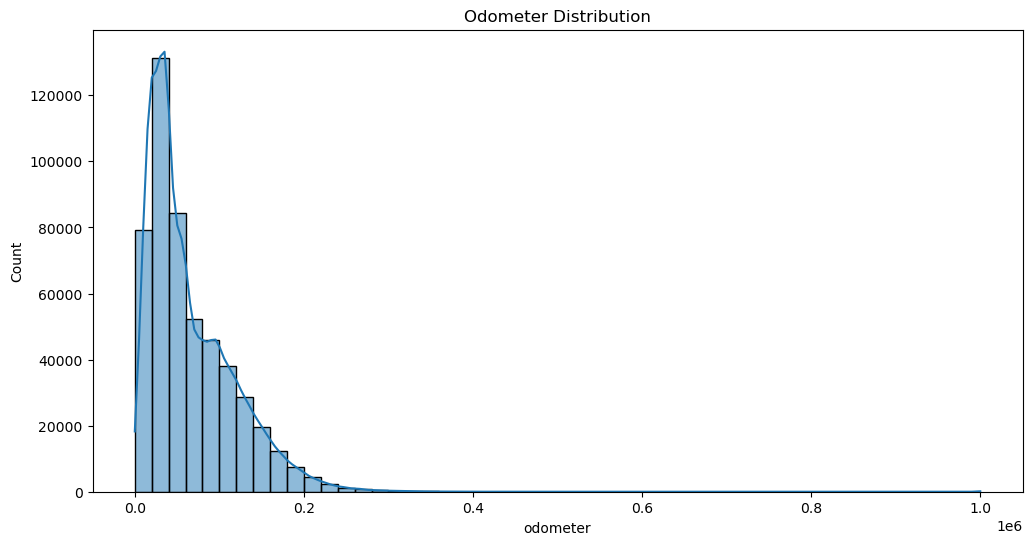

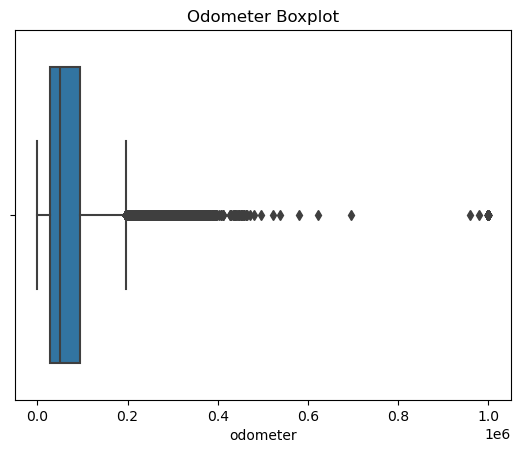

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram ve boxplot
plt.figure(figsize=(12, 6))
sns.histplot(df['odometer'], kde=True, bins=50)
plt.title('Odometer Distribution')
plt.show()

sns.boxplot(x=df['odometer'])
plt.title('Odometer Boxplot')
plt.show()

##### Veri seti çok büyük normal dağılmıyor çarpıklık ve basıklık var yüksek miktarda bu yüzden çarpıklığa biraz müdahele edip sonrasında outlier analizi yapmak daha mantıklı

##### Logaritma dönüşümü veya box-cox dönüşümü, veri sağa doğru aşırı çarpık olduğunda karkök dönüşümünün yerine daha çok uygun oluyor
##### Özellikle bizim verimizde sağa doğru aşırı çarpıklık var box-cox kullanmamız daha faydalı olur

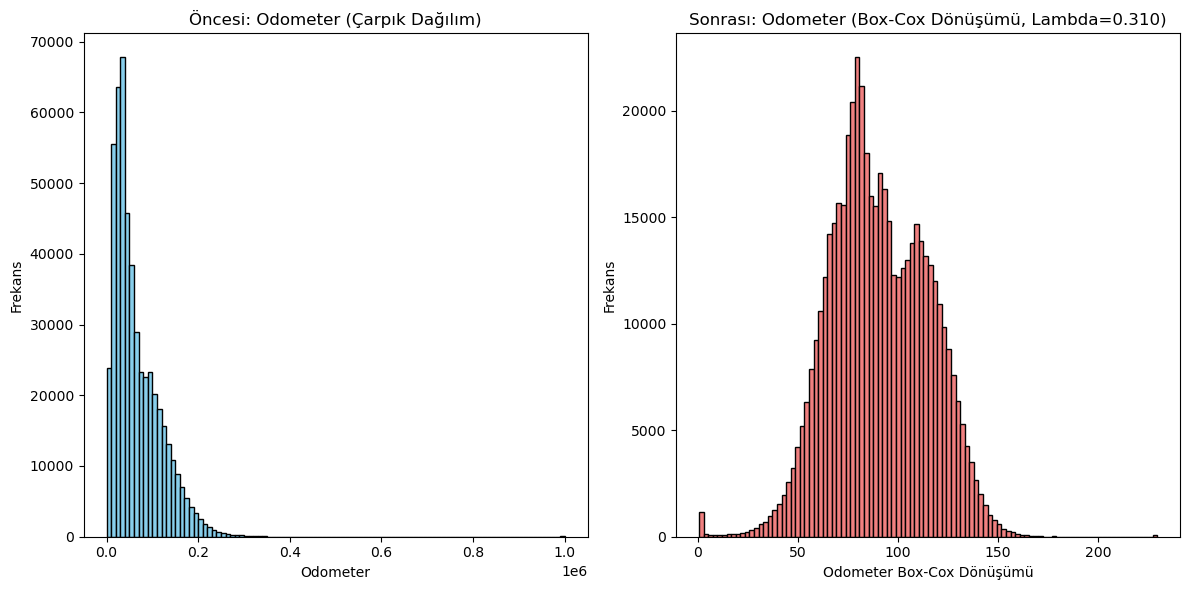

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats



# DataFrame oluşturuyoruz
df_box_cox = pd.DataFrame(df, columns=['odometer'])

# 1. Adım: Verinin Çarpık Halini Görselleştirme (Öncesi)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_box_cox['odometer'], bins=100, color='skyblue', edgecolor='black')
plt.title("Öncesi: Odometer (Çarpık Dağılım)")
plt.xlabel("Odometer")
plt.ylabel("Frekans")

# 2. Adım: Box-Cox Dönüşümünü Uygulama
df_box_cox['odometer_boxcox'], lambda_value = stats.boxcox(df_box_cox['odometer'] + 1)  # Box-Cox dönüşümü (sıfır olmayan veriler için 1 ekleyerek)

# 3. Adım: Dönüştürülmüş Veriyi Görselleştirme (Sonrası)
plt.subplot(1, 2, 2)
plt.hist(df_box_cox['odometer_boxcox'], bins=100, color='lightcoral', edgecolor='black')
plt.title(f"Sonrası: Odometer (Box-Cox Dönüşümü, Lambda={lambda_value:.3f})")
plt.xlabel("Odometer Box-Cox Dönüşümü")
plt.ylabel("Frekans")

# Grafikleri göster
plt.tight_layout()
plt.show()


In [114]:
df_box_cox.drop(columns=['odometer'],inplace=True)
df['odometer_box_cox']=df_box_cox

In [116]:
df['odometer_box_cox']

0         62.253151
1         51.629277
2         26.733026
3         59.228459
4         33.810360
            ...    
558832    64.159540
558833    91.262535
558834    89.149211
558835    62.276292
558836    60.194654
Name: odometer_box_cox, Length: 509612, dtype: float64

### IQR ve Z-Score Modelin normal dağılmasını ve çarpık olmamasını ön koşul alır daha esnek yöntemler denersek LOF veya isolation forest gibi daha esnek yöntemler deneyebiliriz

In [ ]:
## İSOLATİON FOREST

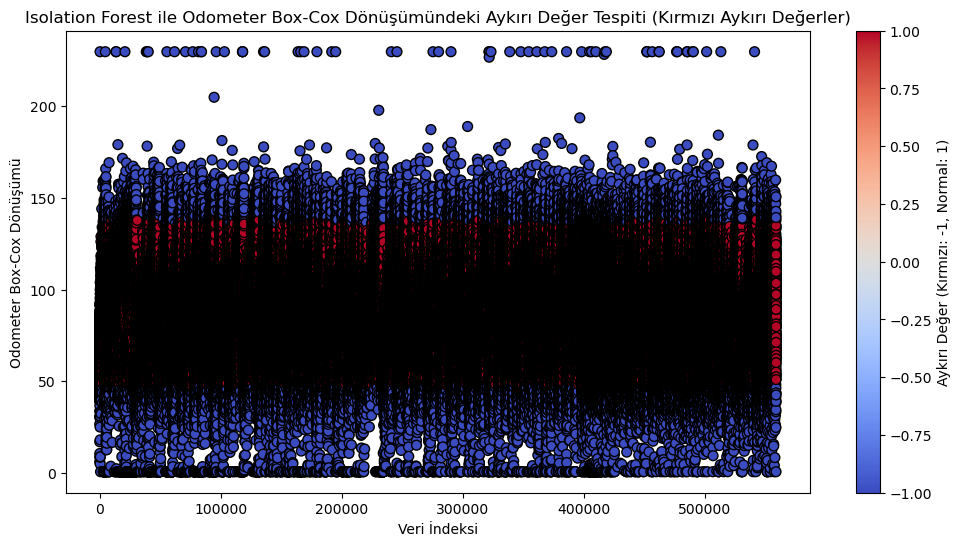

Aykırı Değerler:         odometer_box_cox  anomaly
2              26.733026       -1
4              33.810360       -1
5              43.393539       -1
9              41.360459       -1
11             30.934430       -1
...                  ...      ...
558778          0.773146       -1
558779         43.713321       -1
558782         39.106286       -1
558786         42.593547       -1
558791        150.523465       -1

[25456 rows x 2 columns]
Toplam Aykırı Değer Sayısı: 25456


In [118]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy import stats

#veri (Odometer Box-Cox Dönüşümü sonrası)

df_data = pd.DataFrame(df, columns=['odometer_box_cox'])



# 1. Aykırı Değer Tespiti için Isolation Forest Modeli Kurulumu
model = IsolationForest(contamination=0.05, random_state=42)  # contamination: Aykırı değerlerin tahmin edilen oranı

# 2. Modeli Eğitme ve Aykırı Değerleri Tahmin Etme (odometer_box_cox üzerinde)
df_data['anomaly'] = model.fit_predict(df_data[['odometer_box_cox']])

# 3. Aykırı Değerleri -1 (aykırı) ve 1 (normal) ile işaretler
# -1: Aykırı değer, 1: Normal değer

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.scatter(df_data.index, df_data['odometer_box_cox'], c=df_data['anomaly'], cmap='coolwarm', edgecolors='k', s=50)
plt.title("Isolation Forest ile Odometer Box-Cox Dönüşümündeki Aykırı Değer Tespiti (Kırmızı Aykırı Değerler)")
plt.xlabel('Veri İndeksi')
plt.ylabel('Odometer Box-Cox Dönüşümü')
plt.colorbar(label='Aykırı Değer (Kırmızı: -1, Normal: 1)')
plt.show()

# Aykırı Değerlerin Tespiti ve Filtrelenmesi (İsteğe bağlı)
outliers_removed = df_data[df_data['anomaly'] == 1]  # Aykırı olmayan değerler
outliers = df_data[df_data['anomaly'] == -1]  # Aykırı değerler

print(f"Aykırı Değerler: {outliers}")
print(f"Toplam Aykırı Değer Sayısı: {len(outliers)}")



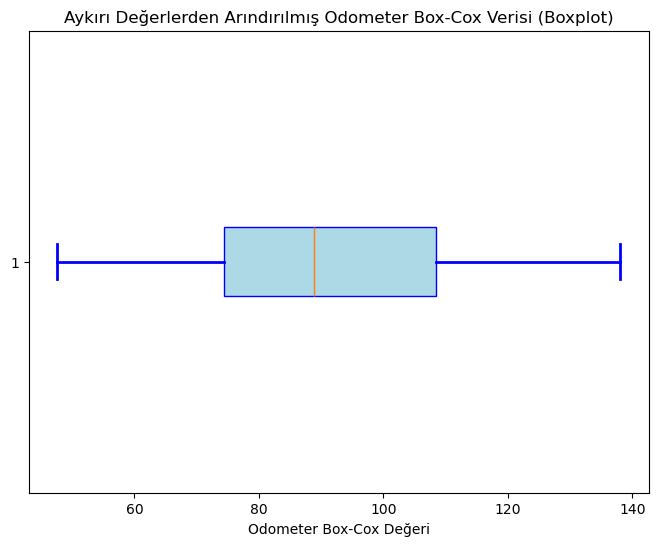

In [120]:
import matplotlib.pyplot as plt

# Aykırı Değerlerden Arındırılmış Verinin Boxplot'u
plt.figure(figsize=(8, 6))
plt.boxplot(outliers_removed['odometer_box_cox'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue', linewidth=2),
            capprops=dict(color='blue', linewidth=2))
plt.title("Aykırı Değerlerden Arındırılmış Odometer Box-Cox Verisi (Boxplot)")
plt.xlabel('Odometer Box-Cox Değeri')
plt.show()


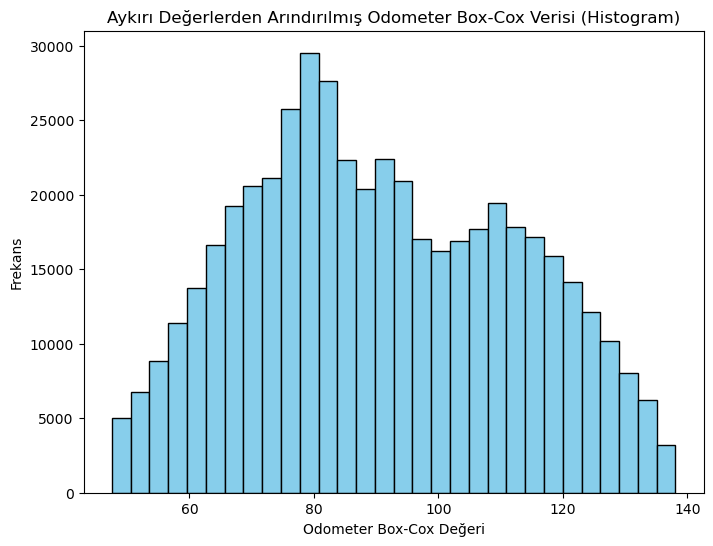

In [122]:
import matplotlib.pyplot as plt

# Aykırı Değerlerden Arındırılmış Verinin Histogram'ı
plt.figure(figsize=(8, 6))
plt.hist(outliers_removed['odometer_box_cox'], bins=30, color='skyblue', edgecolor='black')
plt.title("Aykırı Değerlerden Arındırılmış Odometer Box-Cox Verisi (Histogram)")
plt.xlabel('Odometer Box-Cox Değeri')
plt.ylabel('Frekans')
plt.show()


##### mmr

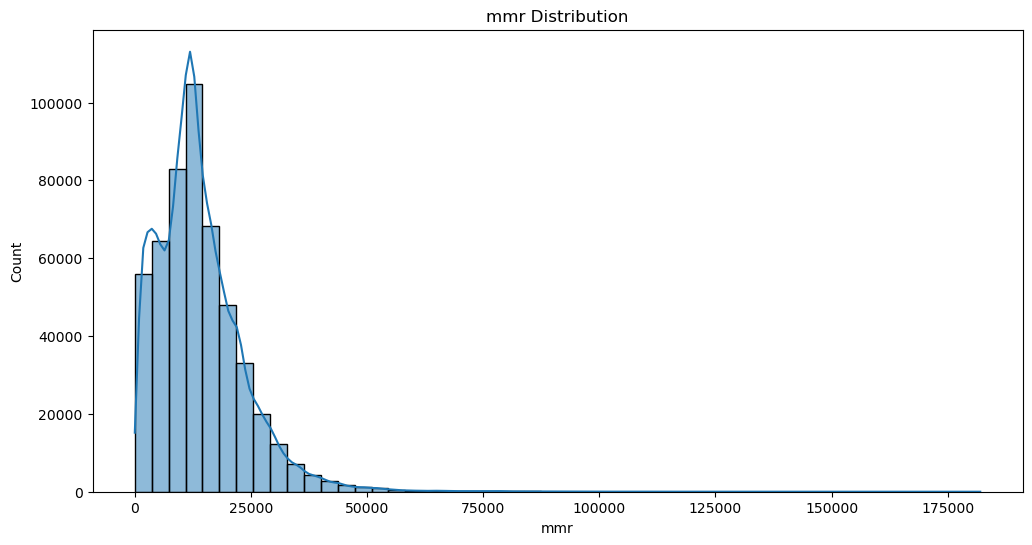

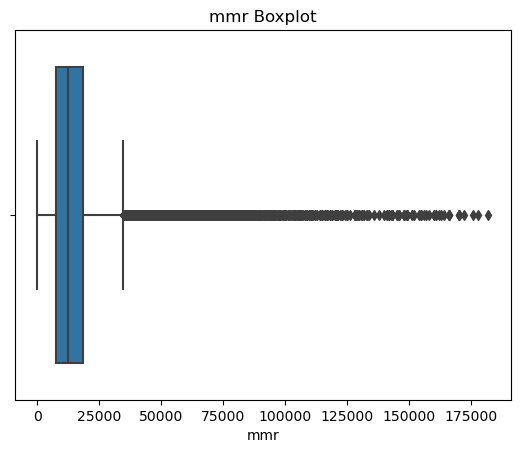

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram ve boxplot
plt.figure(figsize=(12, 6))
sns.histplot(df['mmr'], kde=True, bins=50)
plt.title('mmr Distribution')
plt.show()

sns.boxplot(x=df['mmr'])
plt.title('mmr Boxplot')
plt.show()

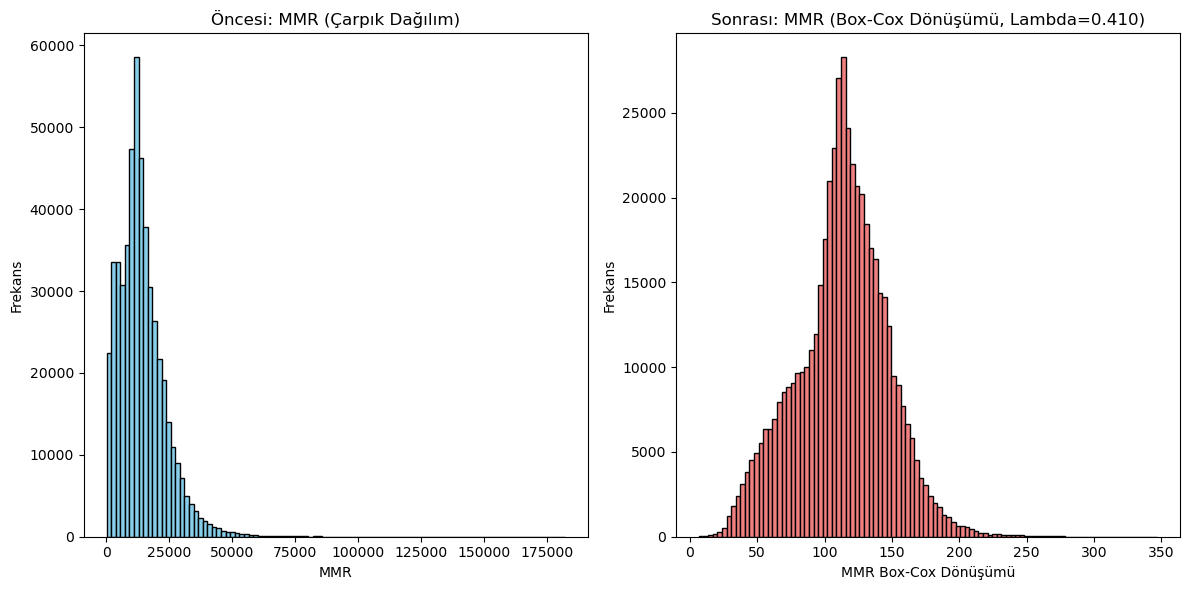

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# DataFrame oluşturuyoruz
df_box_cox = pd.DataFrame(df, columns=['mmr'])  # 'odometer' yerine 'mmr' kullanıyoruz

# 1. Adım: Verinin Çarpık Halini Görselleştirme (Öncesi)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_box_cox['mmr'], bins=100, color='skyblue', edgecolor='black')
plt.title("Öncesi: MMR (Çarpık Dağılım)")
plt.xlabel("MMR")
plt.ylabel("Frekans")

# 2. Adım: Box-Cox Dönüşümünü Uygulama
df_box_cox['mmr_boxcox'], lambda_value = stats.boxcox(df_box_cox['mmr'] + 1)  # Box-Cox dönüşümü (sıfır olmayan veriler için 1 ekleyerek)

# 3. Adım: Dönüştürülmüş Veriyi Görselleştirme (Sonrası)
plt.subplot(1, 2, 2)
plt.hist(df_box_cox['mmr_boxcox'], bins=100, color='lightcoral', edgecolor='black')
plt.title(f"Sonrası: MMR (Box-Cox Dönüşümü, Lambda={lambda_value:.3f})")
plt.xlabel("MMR Box-Cox Dönüşümü")
plt.ylabel("Frekans")

# Grafikleri göster
plt.tight_layout()
plt.show()


In [136]:
df_box_cox.drop(columns=['mmr'],inplace=True)
df['mmr_box_cox']=df_box_cox

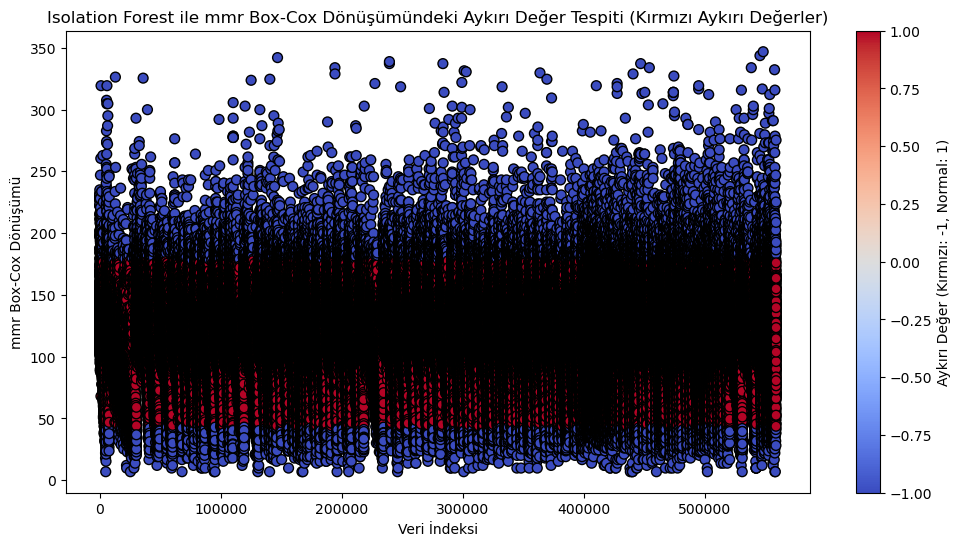

Aykırı Değerler:         mmr_box_cox  anomaly
4        228.041497       -1
6        232.278868       -1
10       198.626687       -1
17       179.575392       -1
19       230.878713       -1
...             ...      ...
558775   186.426036       -1
558777   208.712664       -1
558807   225.153075       -1
558816   275.259073       -1
558824   192.572718       -1

[25444 rows x 2 columns]
Toplam Aykırı Değer Sayısı: 25444


In [141]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy import stats

#veri (mmr_box_cox Dönüşümü sonrası)

df_data = pd.DataFrame(df, columns=['mmr_box_cox'])



# 1. Aykırı Değer Tespiti için Isolation Forest Modeli Kurulumu
model = IsolationForest(contamination=0.05, random_state=42)  # contamination: Aykırı değerlerin tahmin edilen oranı

# 2. Modeli Eğitme ve Aykırı Değerleri Tahmin Etme (odometer_box_cox üzerinde)
df_data['anomaly'] = model.fit_predict(df_data[['mmr_box_cox']])

# 3. Aykırı Değerleri -1 (aykırı) ve 1 (normal) ile işaretler
# -1: Aykırı değer, 1: Normal değer

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.scatter(df_data.index, df_data['mmr_box_cox'], c=df_data['anomaly'], cmap='coolwarm', edgecolors='k', s=50)
plt.title("Isolation Forest ile mmr Box-Cox Dönüşümündeki Aykırı Değer Tespiti (Kırmızı Aykırı Değerler)")
plt.xlabel('Veri İndeksi')
plt.ylabel('mmr Box-Cox Dönüşümü')
plt.colorbar(label='Aykırı Değer (Kırmızı: -1, Normal: 1)')
plt.show()

# Aykırı Değerlerin Tespiti ve Filtrelenmesi (İsteğe bağlı)
outliers_removed = df_data[df_data['anomaly'] == 1]  # Aykırı olmayan değerler
outliers = df_data[df_data['anomaly'] == -1]  # Aykırı değerler

print(f"Aykırı Değerler: {outliers}")
print(f"Toplam Aykırı Değer Sayısı: {len(outliers)}")


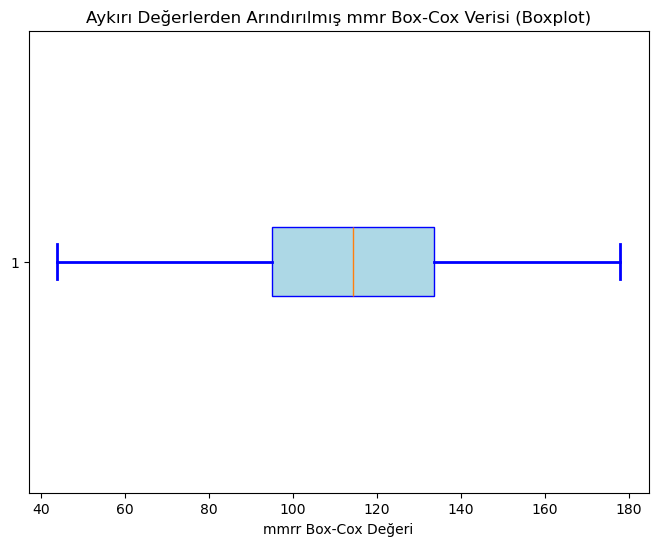

In [143]:
import matplotlib.pyplot as plt

# Aykırı Değerlerden Arındırılmış Verinin Boxplot'u
plt.figure(figsize=(8, 6))
plt.boxplot(outliers_removed['mmr_box_cox'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue', linewidth=2),
            capprops=dict(color='blue', linewidth=2))
plt.title("Aykırı Değerlerden Arındırılmış mmr Box-Cox Verisi (Boxplot)")
plt.xlabel('mmrr Box-Cox Değeri')
plt.show()

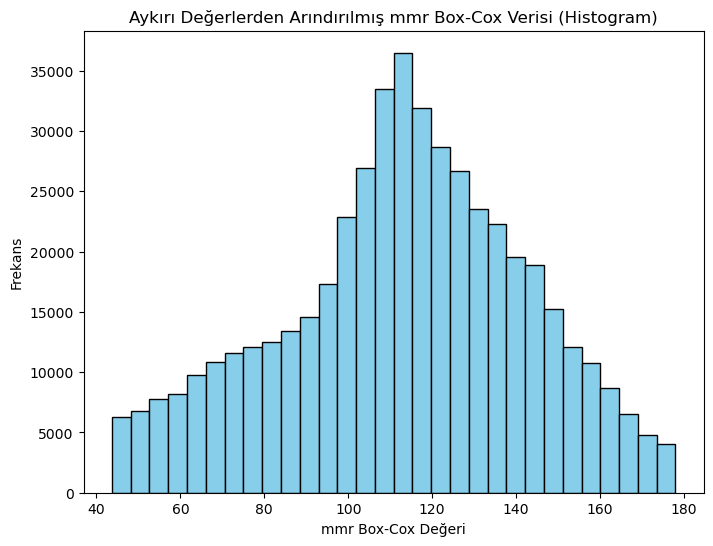

In [145]:
import matplotlib.pyplot as plt

# Aykırı Değerlerden Arındırılmış Verinin Histogram'ı
plt.figure(figsize=(8, 6))
plt.hist(outliers_removed['mmr_box_cox'], bins=30, color='skyblue', edgecolor='black')
plt.title("Aykırı Değerlerden Arındırılmış mmr Box-Cox Verisi (Histogram)")
plt.xlabel('mmr Box-Cox Değeri')
plt.ylabel('Frekans')
plt.show()


#### Numerik bağımlı değişken için outlier analizi

##### sellingprice

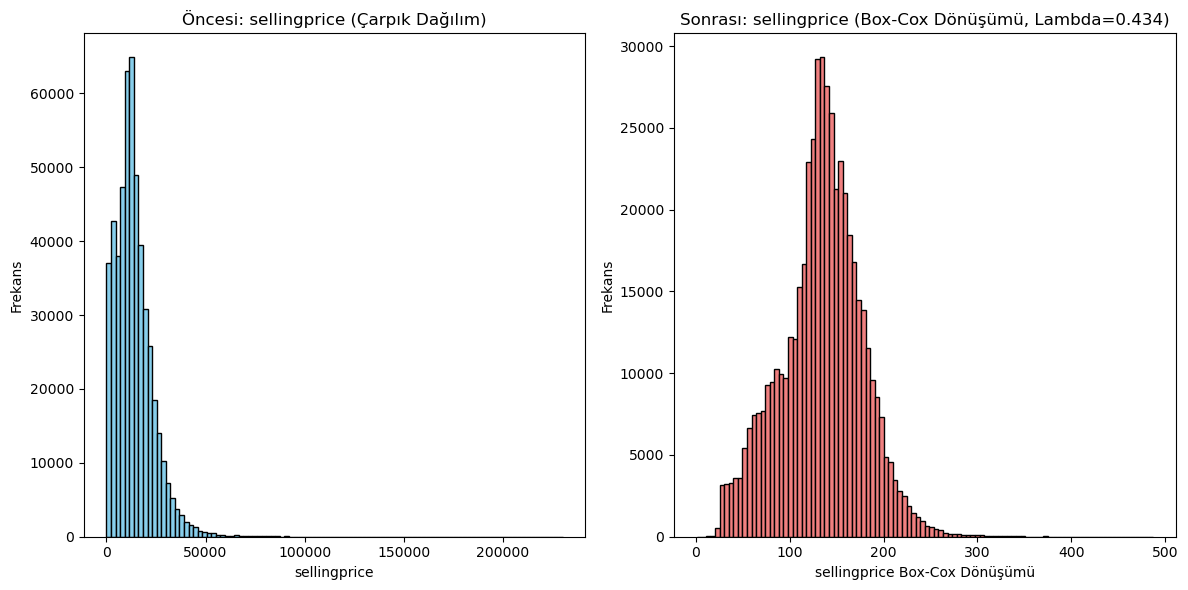

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# DataFrame oluşturuyoruz
df_box_cox = pd.DataFrame(df, columns=['sellingprice']) 

# 1. Adım: Verinin Çarpık Halini Görselleştirme (Öncesi)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_box_cox['sellingprice'], bins=100, color='skyblue', edgecolor='black')
plt.title("Öncesi: sellingprice (Çarpık Dağılım)")
plt.xlabel("sellingprice")
plt.ylabel("Frekans")

# 2. Adım: Box-Cox Dönüşümünü Uygulama
df_box_cox['sellingprice_boxcox'], lambda_value = stats.boxcox(df_box_cox['sellingprice'] + 1)  # Box-Cox dönüşümü (sıfır olmayan veriler için 1 ekleyerek)

# 3. Adım: Dönüştürülmüş Veriyi Görselleştirme (Sonrası)
plt.subplot(1, 2, 2)
plt.hist(df_box_cox['sellingprice_boxcox'], bins=100, color='lightcoral', edgecolor='black')
plt.title(f"Sonrası: sellingprice (Box-Cox Dönüşümü, Lambda={lambda_value:.3f})")
plt.xlabel("sellingprice Box-Cox Dönüşümü")
plt.ylabel("Frekans")

# Grafikleri göster
plt.tight_layout()
plt.show()

In [153]:
df_box_cox.drop(columns=['sellingprice'],inplace=True)
df['sellingprice_box_cox']=df_box_cox

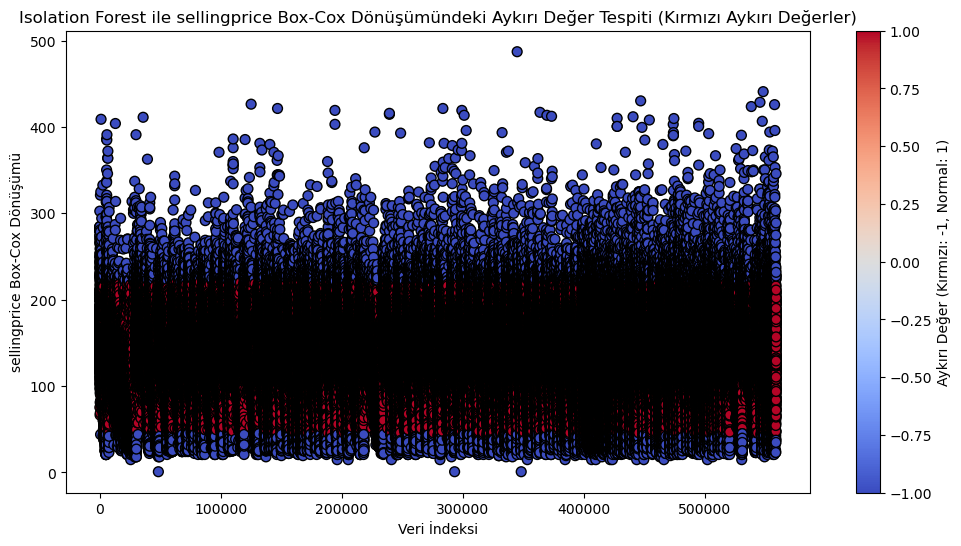

Aykırı Değerler:         sellingprice_box_cox  anomaly
4                 284.193999       -1
6                 280.450350       -1
10                249.470178       -1
17                226.727736       -1
19                284.564866       -1
...                      ...      ...
558775            227.965904       -1
558777            227.347908       -1
558807            288.785685       -1
558816            345.876920       -1
558824            231.629332       -1

[25446 rows x 2 columns]
Toplam Aykırı Değer Sayısı: 25446


In [155]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy import stats

#veri (selling_box_cox Dönüşümü sonrası)

df_data = pd.DataFrame(df, columns=['sellingprice_box_cox'])



# 1. Aykırı Değer Tespiti için Isolation Forest Modeli Kurulumu
model = IsolationForest(contamination=0.05, random_state=42)  # contamination: Aykırı değerlerin tahmin edilen oranı

# 2. Modeli Eğitme ve Aykırı Değerleri Tahmin Etme (odometer_box_cox üzerinde)
df_data['anomaly'] = model.fit_predict(df_data[['sellingprice_box_cox']])

# 3. Aykırı Değerleri -1 (aykırı) ve 1 (normal) ile işaretler
# -1: Aykırı değer, 1: Normal değer

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.scatter(df_data.index, df_data['sellingprice_box_cox'], c=df_data['anomaly'], cmap='coolwarm', edgecolors='k', s=50)
plt.title("Isolation Forest ile sellingprice Box-Cox Dönüşümündeki Aykırı Değer Tespiti (Kırmızı Aykırı Değerler)")
plt.xlabel('Veri İndeksi')
plt.ylabel('sellingprice Box-Cox Dönüşümü')
plt.colorbar(label='Aykırı Değer (Kırmızı: -1, Normal: 1)')
plt.show()

# Aykırı Değerlerin Tespiti ve Filtrelenmesi (İsteğe bağlı)
outliers_removed = df_data[df_data['anomaly'] == 1]  # Aykırı olmayan değerler
outliers = df_data[df_data['anomaly'] == -1]  # Aykırı değerler

print(f"Aykırı Değerler: {outliers}")
print(f"Toplam Aykırı Değer Sayısı: {len(outliers)}")


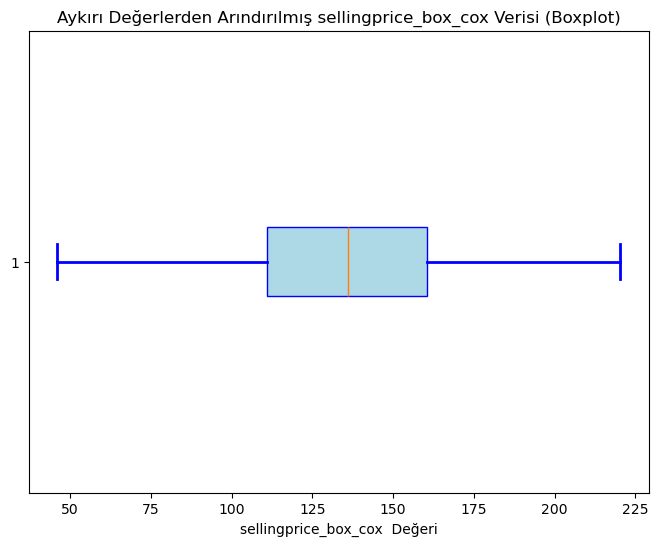

In [157]:
import matplotlib.pyplot as plt

# Aykırı Değerlerden Arındırılmış Verinin Boxplot'u
plt.figure(figsize=(8, 6))
plt.boxplot(outliers_removed['sellingprice_box_cox'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue', linewidth=2),
            capprops=dict(color='blue', linewidth=2))
plt.title("Aykırı Değerlerden Arındırılmış sellingprice_box_cox Verisi (Boxplot)")
plt.xlabel('sellingprice_box_cox  Değeri')
plt.show()

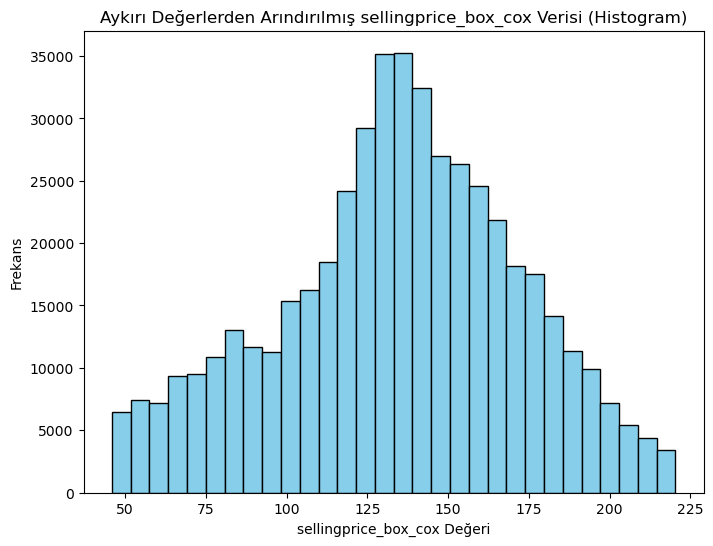

In [159]:
import matplotlib.pyplot as plt

# Aykırı Değerlerden Arındırılmış Verinin Histogram'ı
plt.figure(figsize=(8, 6))
plt.hist(outliers_removed['sellingprice_box_cox'], bins=30, color='skyblue', edgecolor='black')
plt.title("Aykırı Değerlerden Arındırılmış sellingprice_box_cox Verisi (Histogram)")
plt.xlabel('sellingprice_box_cox Değeri')
plt.ylabel('Frekans')
plt.show()
